### Day 13: Parallel and GPU‑Accelerated Optimization Techniques
In large-scale optimization, speed is critical. Today, we learn two methods:

Multiprocessing: Run many independent LP optimizations in parallel to perform sensitivity analysis.   
GPU Acceleration: Use PyTorch to run gradient descent on a function quickly using a GPU.  

#### Part 1: Multiprocessing for Sensitivity Analysis  
We use an LP problem defined as follows:

Objective: Minimize f(x,y) = -3x - 5y (i.e. maximize 3x+5y)  
Constraints:  
2x + 3y ≤ b1  
x + 2y ≤ b2  
x, y ≥ 0  
We will vary b1 and b2 over specified ranges and solve the LP in parallel.

In [8]:
!pip install pathos

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from pathos.multiprocessing import ProcessingPool as Pool  # Use pathos' Pool


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [9]:
# Define the LP function at the top level in your notebook
def solve_lp(rhs):
    # rhs is a tuple (b1, b2)
    b1, b2 = rhs
    # Coefficients for the objective function: minimize -3x - 5y (equivalent to maximizing 3x+5y)
    c = [-3, -5]
    # Constraint matrix: 2x + 3y <= b1, and x + 2y <= b2
    A = [[2, 3],
         [1, 2]]
    # Bounds for x and y: x, y >= 0
    bounds = [(0, None), (0, None)]
    # Solve the LP
    res = linprog(c=c, A_ub=A, b_ub=[b1, b2], bounds=bounds, method="highs")
    # Return the RHS values and the minimized objective value
    return (b1, b2, res.fun)

In [10]:
# Define ranges for b1 and b2 for sensitivity analysis
b1_range = np.arange(16, 25, 1)  # For constraint 1: 2x+3y <= b1
b2_range = np.arange(6, 13, 1)   # For constraint 2: x+2y <= b2

# Create a list of (b1, b2) tuples for all combinations
rhs_list = [(b1, b2) for b1 in b1_range for b2 in b2_range]

# Use the pathos ProcessingPool to run the LP optimizations in parallel
with Pool() as pool:
    results = pool.map(solve_lp, rhs_list)

print("Sensitivity analysis results")
print(results)


Sensitivity analysis results
[(np.int64(16), np.int64(6), -18.000000000000014), (np.int64(16), np.int64(7), -21.000000000000004), (np.int64(16), np.int64(8), -24.0), (np.int64(16), np.int64(9), -25.0), (np.int64(16), np.int64(10), -26.0), (np.int64(16), np.int64(11), -26.666666666666664), (np.int64(16), np.int64(12), -26.666666666666664), (np.int64(17), np.int64(6), -18.000000000000014), (np.int64(17), np.int64(7), -21.000000000000004), (np.int64(17), np.int64(8), -24.0), (np.int64(17), np.int64(9), -26.0), (np.int64(17), np.int64(10), -27.000000000000004), (np.int64(17), np.int64(11), -28.0), (np.int64(17), np.int64(12), -28.333333333333336), (np.int64(18), np.int64(6), -18.000000000000014), (np.int64(18), np.int64(7), -21.000000000000004), (np.int64(18), np.int64(8), -24.0), (np.int64(18), np.int64(9), -27.0), (np.int64(18), np.int64(10), -28.0), (np.int64(18), np.int64(11), -29.0), (np.int64(18), np.int64(12), -30.0), (np.int64(19), np.int64(6), -18.000000000000014), (np.int64(19), 

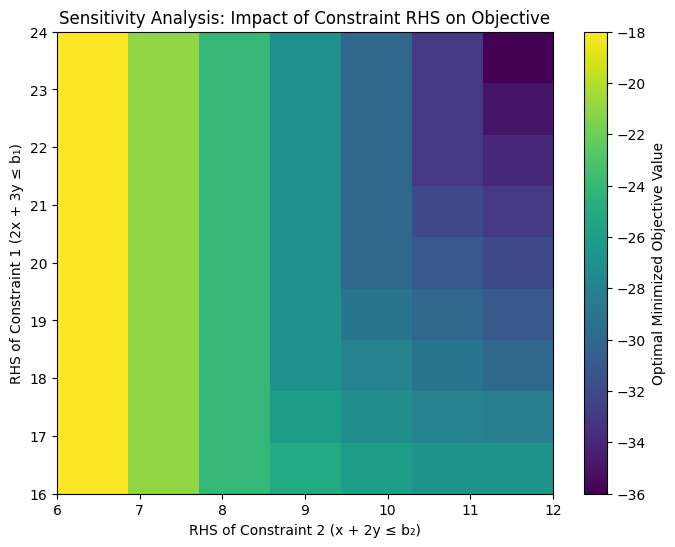

In [11]:
# Visualize the problem

import matplotlib.pyplot as plt

# Reshape the results into a grid for plotting.
# The grid shape is (len(b1_range), len(b2_range))
objective_grid = np.zeros((len(b1_range), len(b2_range)))
for r in results:
    b1, b2, obj = r
    i = int(b1 - b1_range[0])  # index based on b1_range
    j = int(b2 - b2_range[0])  # index based on b2_range
    objective_grid[i, j] = obj

# Create the heatmap.
plt.figure(figsize=(8, 6))
extent = [b2_range[0], b2_range[-1], b1_range[0], b1_range[-1]]
im = plt.imshow(objective_grid, origin='lower', extent=extent, aspect='auto', cmap='viridis')
plt.colorbar(im, label='Optimal Minimized Objective Value')
plt.xlabel('RHS of Constraint 2 (x + 2y ≤ b₂)')
plt.ylabel('RHS of Constraint 1 (2x + 3y ≤ b₁)')
plt.title('Sensitivity Analysis: Impact of Constraint RHS on Objective')
plt.show()

#### Part 2: GPU-Accelerated Optimization with PyTorch

We now perform gradient descent on a simple function using PyTorch. We choose a quadratic function f(x) = (x - 5)^2. We’ll run gradient descent on the GPU (if available) and print status updates.

In [12]:
# Setup pytorch and select the processing device

!pip install torch

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Running on device: cpu


In [13]:
# Define a variable x, initialize at 0, and require gradients
x = torch.tensor([0.0], requires_grad=True, device=device)

# Use a simple optimizer (Stochastic Gradient Descent) with a fixed learning rate.
optimizer = torch.optim.SGD([x], lr=0.1)

# Run gradient descent for 50 iterations, printing status at every 10 iterations.
for i in range(50):
    optimizer.zero_grad()          # Clear gradients
    loss = (x - 5)**2              # Compute the loss: (x-5)^2
    loss.backward()                # Compute gradients
    optimizer.step()               # Update x
    if (i+1) % 10 == 0:
        print(f"Iteration {i+1}: x = {x.item():.4f}, loss = {loss.item():.4f}")

print("Final optimal x:", x.item())
print("Final loss:", loss.item())


Iteration 10: x = 4.4631, loss = 0.4504
Iteration 20: x = 4.9424, loss = 0.0052
Iteration 30: x = 4.9938, loss = 0.0001
Iteration 40: x = 4.9993, loss = 0.0000
Iteration 50: x = 4.9999, loss = 0.0000
Final optimal x: 4.9999284744262695
Final loss: 7.951030056574382e-09
